# **Task 2 - Pipeline Proposal**

## **Import Python Libraries Connect to DB**

In [1]:
#pip install pandas
import sqlite3
import pandas as pd

# DB File Path
db_path = "/Users/deepthi.matta/dbt_test_projects/customer_invoices.db"
# Connect to customer_invoices database
conn = sqlite3.connect(db_path)

### **-------------------------------------------------------------------------------------------------------------**

## **Queries - using existing dataset**

### **-------------------------------------------------------------------------------------------------------------**

### **Q1. Capture missing or delayed payments**

In [2]:
query_payment_delay_checks = '''
       with t as (SELECT *,
       CASE WHEN Zahlungsdatum !='NULL' 
       THEN julianday(Zahlungsdatum) - julianday(ReDatum) 
       end AS days_between_invoice_payment,
       CASE WHEN Zahlungsdatum ='NULL' 
       THEN 'Not_paid' 
       WHEN Zahlungsdatum !='NULL' AND julianday(Zahlungsdatum) - julianday(ReDatum) > 7 
       THEN 'Delayed_Payment' 
       ELSE 'Paid' END AS payment_status
       FROM Abrechnung_Rechnungen 
       where (kdnr != 'NULL' and kdnr>0) and (Renummer != 'NULL' and renummer > 0) )
       select * from t where payment_status not in ('Paid');'''

dataframe_payment_delay_checks = pd.read_sql_query(query_payment_delay_checks, conn)

# Display the output
dataframe_payment_delay_checks

,ReNummer,SummeNetto,MwStSatz,ZahlungsbetragBrutto,KdNr,Summenebenkosten,ReDatum,Zahlungsdatum,days_between_invoice_payment,payment_status
0,101603,375.0,7,401.25,20843,0,2024-11-04 00:00:00.000,2024-11-28 00:00:00.000,24.0,Delayed_Payment
1,101604,94.5,7,101.12,20843,0,2024-11-04 00:00:00.000,2024-11-18 00:00:00.000,14.0,Delayed_Payment
2,101605,3450.0,7,3691.5,20020,0,2024-11-04 00:00:00.000,2024-11-12 00:00:00.000,8.0,Delayed_Payment
3,101607,45.0,7,48.15,75685,0,2024-11-04 00:00:00.000,2024-11-12 00:00:00.000,8.0,Delayed_Payment
4,101608,500.0,7,535,80531,0,2024-11-04 00:00:00.000,2025-01-16 00:00:00.000,73.0,Delayed_Payment
...,...,...,...,...,...,...,...,...,...,...
1368,103597,1260.0,7,0,20213,0,2025-04-03 00:00:00.000,NULL,NaN,Not_paid
1369,103598,225.0,7,0,10383,0,2025-04-01 00:00:00.000,NULL,NaN,Not_paid
1370,103599,160.0,7,0,30145,0,2025-04-04 00:00:00.000,NULL,NaN,Not_paid
1371,103600,379.0,7,0,79666,0,2025-04-03 00:00:00.000,NULL,NaN,Not_paid


### **-------------------------------------------------------------------------------------------------------------**

### **Q2. Flag or isolate “placeholder” media positions**

In [3]:
query_placeholder_position_flag = '''
       with t as (SELECT *, 
       CASE WHEN Bildnummer = 100000000 THEN 1 ELSE 0 END AS is_placeholder
       FROM Abrechnung_Positionen
       WHERE (kdnr != 'NULL' and kdnr>0) and (Reid != 'NULL' and reid > 0))
       select * from t where is_placeholder = 1'''

dataframe_placeholder_position_flag = pd.read_sql_query(query_placeholder_position_flag, conn)

# Display the output
dataframe_placeholder_position_flag

,id,ReId,KdNr,Nettobetrag,Bildnummer,VerDatum,is_placeholder
0,4142217,101703,79345,425.00,100000000,2022-06-01 00:00:00.000,1
1,4142761,101721,72880,49.00,100000000,2022-08-01 00:00:00.000,1
2,4142762,101721,72880,49.00,100000000,2022-08-01 00:00:00.000,1
3,4142763,101721,72880,49.00,100000000,2022-08-01 00:00:00.000,1
4,4142764,101721,72880,49.00,100000000,2022-08-01 00:00:00.000,1
...,...,...,...,...,...,...,...
2402,5726950,103209,10813,12.00,100000000,2025-02-25 00:00:00.000,1
2403,5726951,103209,10813,12.00,100000000,2025-02-25 00:00:00.000,1
2404,5726952,103209,10813,12.00,100000000,2025-02-23 00:00:00.000,1
2405,5726953,103209,10813,0.24,100000000,2025-02-15 00:00:00.000,1


### **-------------------------------------------------------------------------------------------------------------**

### **Q3. Improve data quality validation upstream - Query to capture invalid data fields**

In [4]:
# Run SQL query -  Check for NULL value in the fields.
query_invalid_data_checks = '''
with t as 
        (select count(1) as cnt, 'id' as col_nm , 'Abrechnung_Kunden' AS table_name 
        from Abrechnung_Kunden where id ='NULL'
        union 
        select count(1) , 'Kdnr' as col_nm , 'Abrechnung_Kunden' AS table_name 
        from Abrechnung_Kunden where Kdnr ='NULL' or Kdnr < 0 
        union 
        select count(1) , 'id' as col_nm , 'Abrechnung_Positionen' AS table_name 
        from Abrechnung_Positionen where id ='NULL'
        union 
        select count(1) , 'Reid' as col_nm , 'Abrechnung_Positionen' AS table_name 
        from Abrechnung_Positionen where Reid ='NULL' or Reid < 0 
        union 
        select count(1) , 'KdNr' as col_nm , 'Abrechnung_Positionen' AS table_name 
        from Abrechnung_Positionen where KdNr ='NULL' or KdNr < 0
        union 
        select count(1) , 'Nettobetrag' as col_nm, 'Abrechnung_Positionen' AS table_name 
        from Abrechnung_Positionen where Nettobetrag ='NULL' 
        or (Nettobetrag <= 0 and Bildnummer != 100000000)
        union 
        select count(1) , 'Bildnummer' as col_nm, 'Abrechnung_Positionen' AS table_name 
        from Abrechnung_Positionen where Bildnummer ='NULL' 
        union 
        select count(1) , 'VerDatum' as col_nm, 'Abrechnung_Positionen' AS table_name 
        from Abrechnung_Positionen where VerDatum ='NULL'
        union 
        select count(1) , 'ReNummer' as col_nm , 'Abrechnung_Rechnungen' AS table_name 
        from Abrechnung_Rechnungen where ReNummer ='NULL' and ReNummer < 0
        union 
        select count(1) , 'SummeNetto' as col_nm , 'Abrechnung_Rechnungen' AS table_name 
        from Abrechnung_Rechnungen where SummeNetto ='NULL' and SummeNetto <= 0
        union 
        select count(1) , 'ZahlungsbetragBrutto' as col_nm , 'Abrechnung_Rechnungen' AS table_name
        from Abrechnung_Rechnungen where ZahlungsbetragBrutto ='NULL' 
        and ZahlungsbetragBrutto <= 0
        union 
        select count(1) , 'KdNr' as col_nm , 'Abrechnung_Rechnungen' AS table_name 
        from Abrechnung_Rechnungen where KdNr ='NULL'  or KdNr < 0
        union 
        select count(1) , 'ReDatum' as col_nm, 'Abrechnung_Rechnungen' AS table_name 
        from Abrechnung_Rechnungen where ReDatum ='NULL'
        order by table_name, col_nm)
        select * from t where cnt > 0
        ;
       '''

dataframe_invalid_data_checks = pd.read_sql_query(query_invalid_data_checks, conn)

# Display the output
dataframe_invalid_data_checks


,cnt,col_nm,table_name
0,1,Bildnummer,Abrechnung_Positionen
1,1,KdNr,Abrechnung_Positionen
2,24,Nettobetrag,Abrechnung_Positionen
3,4,VerDatum,Abrechnung_Positionen


### **============================================================================**

# **Show Proposed Pipeline as DBT Model Structure as:**


### **============================================================================**

## **Revised data model using DBT**
### **-------------------------------------------------------------------------------------------------------------**

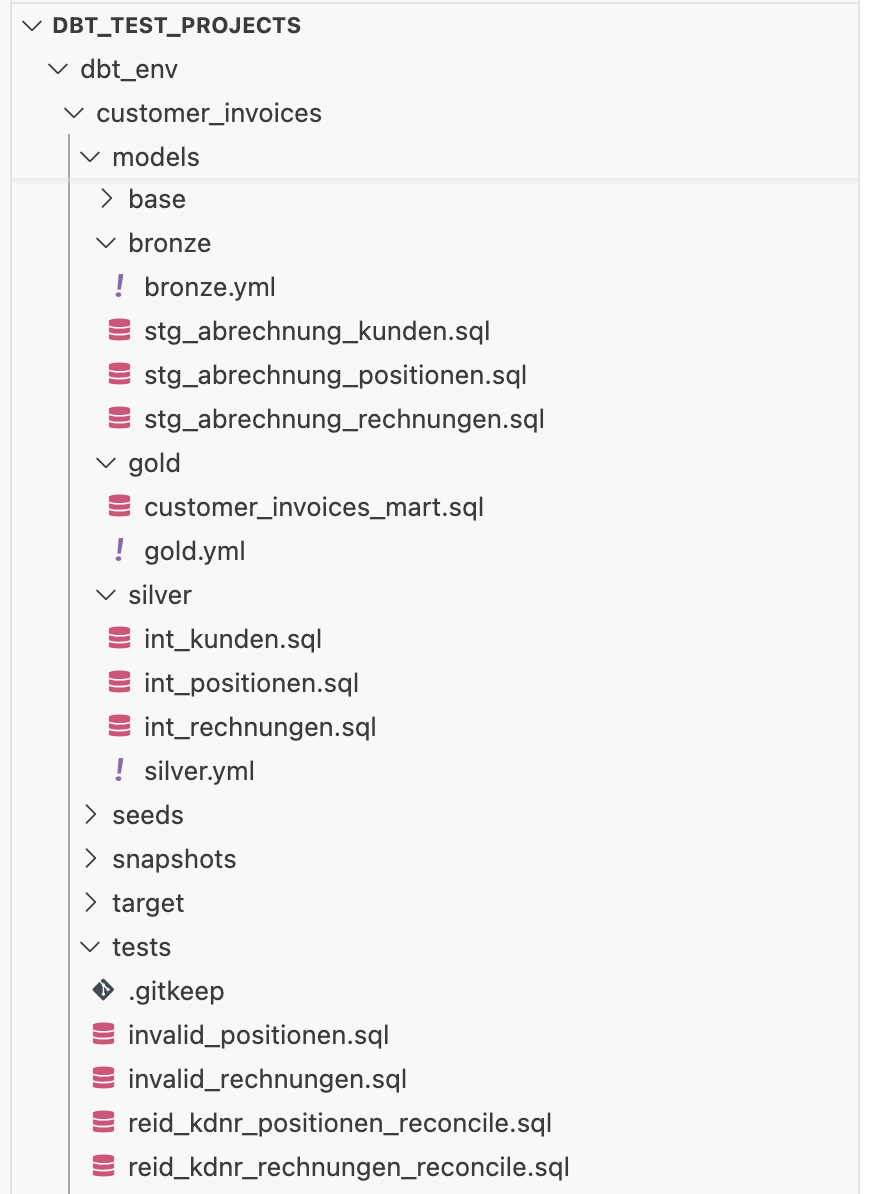

### **GIT Url:**
### **https://github.com/dsv464/deepthi_local/tree/6bf60671d83abe192e6630be7d682e9cd2384dbe/dbt**

### **============================================================================**

## **Assumptions Made for the Reviced Model Implementation**

### 1.KdNr is NULL/'NULL' or KdNr < 0 - Invalid KdNr
### 2.ReId is NULL/'NULL' or ReId < 0 - Invalid ReID
### 3.If the difference between Zahlungsdatum and ReDatum >7 days, consider them as 'Delayed Payments'
### 4.Considering Bildnummer = 100000000 as placeholder data

### **============================================================================**

# **Revised data model - Downstream Impact on Reporting**
## **Benefits of Revised Data Model**
## ***************************************************************************

### **1. Better Data Reconciliation – Ensures Improved Data Quality**  
   ### By clearly separating valid, invalid, and placeholder/test data, the model helps in:  

   ### -> Reconciliating invoice totals with position-level data  
   ### -> Matching payment records with corresponding invoices  
   ### -> Clearly identifying real data gaps or anomalies

### **2. Capturing Invalid Data at the Source**  
   ### Flagging invalid data early in the pipeline enables:  

   ### -> Source teams to review and correct data issues proactively  
   ### -> Filtering out bad records before they impact reporting

### **3. Flagging Placeholder/Test Data and Invalid Entries**  
   ### This helps to:  

   ### -> Avoid data skewness in dashboards and reports  
   ### -> Improve reporting accuracy by excluding placeholder values like Bildnummer = 100000000

### **4. Visibility on Payment Status**  
   ### The introduction of a payment_status field in marts/reports provides:  

   ### -> Highlighting of overdue or missing payments  
   ### -> Clear distinction between actual revenue and expected (unpaid) revenue


### **============================================================================**
# **What business conversations you'd initiate (e.g., with Backoffice or Finance)**

## **Business Questions for Clarification**
## ***************************************************************************

### **1. Payment Delay Threshold**  
   ### Q.What is the defined threshold (in days) after which a payment should be considered delayed?

### **2. Negative or 0 Nettobetrag / Negative Summenebenkosten**  
   ### Q.Are negative or 0 values in Nettobetrag, and negative values in Summenebenkosten, expected?

   ### -> If yes, what do these values represent?  
   ### -> Do they indicate refunds, adjustments, or something else?

### **3. 1 ReId Tagged to Multiple KdNr**  
   ### Q.Should each ReId be uniquely associated with a single KdNr?  
   ### Is it data issue? If not - in which all cases is this expected?

### **4. ZahlungsbetragBrutto < SummeNetto**  
   ### Q.Noticed some cases where ZahlungsbetragBrutto < SummeNetto  
   ### Is this a data issue? 
   ### If not, in which all scenarios this is expected?